<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Semantic Search with Transformer Embeddings</center></font></h1>
<h1><center>With Pinecone</center></h1>
<h3><center>Charlcye Mitchell, May 2024</center></h3>

# **MLS 9: Semantic Search with Transformer Embeddings**
# **Hybrid E-commerce Semantic Search Engine Prototype**

So far, we have only been using text-based data to create NLP applications. However, with a full-fledged E-commerce dataset, we will likely also have access to product images that accompany the product descriptions. In fact, these images also contain rich semantic information about the product that can be used for search and retrieval.

Product images represent an opportunity to also use images for creating high-quality embeddings for Semantic Search. This concept, also called **[Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)** in product application lingo, is now emerging as an increasingly capable method of delivering good user experience through Search.

Theoretically what's required is for us to figure out how to project the product's image into the same latent space as its corresponding text description - that is when we can leverage it to search for products. For example, if a product has an image of a Green T-shirt, the model we choose should ideally produce the same or similar embedding for the image as it should for the text "Green T-shirt". Fortunately for us, OpenAI solved this problem in 2021 with their **[CLIP model](https://openai.com/research/clip)** (Contrastive Language-Image Pre-training), that allows us to use a Transformer-based Neural Network's learnings to project text and images into the same embedding space.

However, there is also a problem with just using the kind of Dense Embeddings that Transformers provide. The problem is with the nature of entities like Brand Names - with purely Dense Embeddings, our model won't effectively capture unique / important words to produce search results where the user has requested for a particular item from a particular brand. Therefore, besides using Dense Embeddings from the images, we shall also use Sparse Embeddings from the text on the product name, brand, color, etc, and these two embedding schemes will be combined in a hybrid manner in our Semantic Search application. This is an example of the utility of the Sparse Embeddings we learned earlier in the program - Sparse and Dense Embeddings are often both required in combination to create the best possible vector representation for data.

Pinecone's **sparse-dense index** allows us to seamlessly perform hybrid search for E-commerce or in any other context.

Therefore, in this notebook, we will perform two levels of innovation to progress beyond simple Dense Vector based Semantic Search on text queries:

**1. Hybrid Dense + Sparse Semantic Search**, but purely with Text Queries, where the Dense component uses OpenAI's CLIP to convert text into a high-quality semantic latent space

**2. Hybrid Dense + Sparse Semantic Search**, but where the Dense component uses an image itself for the query (hence providing scope for Reverse Image Search), while the (optional) Sparse component still relies on Text - this potentially provides the highest quality of search results

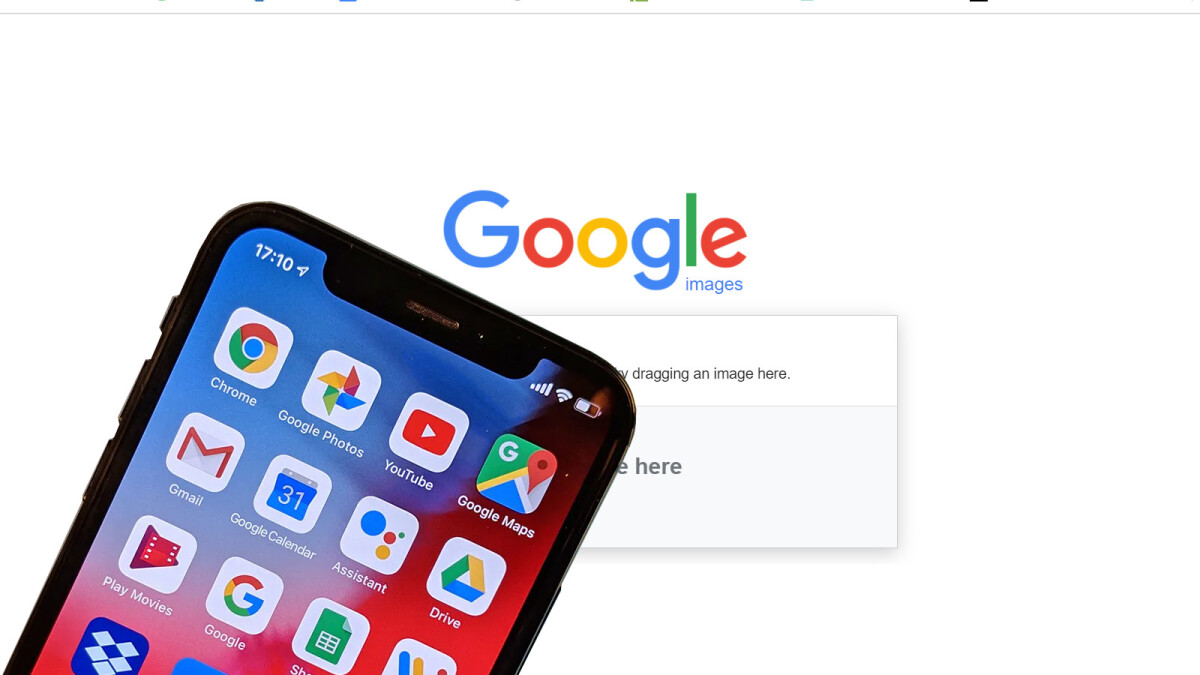

## **1. Installing Dependencies**

First, let's import the necessary libraries:


In [ ]:
!pip install -qU datasets transformers sentence-transformers pinecone-client[grpc]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.5 MB/s eta 0:00:00


## **2. Connecting to Pinecone**

Let's initiate a connection and create an index. For this, we will need a [free API key](https://app.pinecone.io/), and then we initialize the connection like so:

In [ ]:
import os
from pinecone import Pinecone, PodSpec

pc = Pinecone(
    api_key="<Your-API-Key>"
)

In [ ]:
pc.list_indexes().names()

[]

In [ ]:
index_name = "hybrid-image-search"

In [ ]:
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=512,  # dimensionality of minilm
        metric='dotproduct',
        spec=PodSpec(
            environment="gcp-starter"
        )
    )

To use the `sparse-dense` index in Pinecone, we must set `metric="dotproduct"` and use either `s1` or `p1` pods. We also align the `dimension` value to that of our retrieval model, which outputs `512`-dimensional vectors.

The **Dot-Product** metric is being used as it's a better choice for Sparse Embeddings than Euclidean or other distance-oriented metrics. 512 is the dimension size output from tbe CLIP model, and that is the reason we've chosen that hyperparameter.

Now we have created the sparse-dense enabled index, we connect to it:

In [ ]:
index_grpc = pc.Index(index_name)

*Note: We are using `GRPCIndex` rather than `Index` for the improved upsert speeds, either can be used with the sparse-dense index.*

## **3. Loading the Dataset**

We will work with a subset of the **[Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)** dataset, consisting of **~44K fashion products** with images and category labels describing the products. The dataset can be loaded from the Hugging Face Datasets hub as follows:

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

We will first assign the images and metadata into separate variables and then convert the metadata into a Pandas DataFrame.

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

In [ ]:
# display a product image
images[900]

In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We will need **both sparse and dense vectors** to perform hybrid search.

We will use all the metadata fields except for the `id` and `year` to create the sparse vectors, and use the product images to create our dense vectors.

## **4. Sparse Vectors**

To create the sparse vectors we'll use **BM25**, which is a sparse embedding scheme that's a slight improvement on TF-IDF.

For now we'll use a temporary helper function. We download the helper:

In [ ]:
import requests

with open('pinecone_text.py' ,'w') as fb:
    fb.write(requests.get('https://storage.googleapis.com/gareth-pinecone-datasets/pinecone_text.py').text)

The above helper function requires that we pass a tokenizer that will handle the splitting of text into tokens before building the BM25 vectors.

We will use a `bert-base-uncased` tokenizer from Hugging Face `tokenizers`:

In [ ]:
from transformers import BertTokenizerFast
import pinecone_text

# load bert tokenizer from huggingface
tokenizer = BertTokenizerFast.from_pretrained(
    'bert-base-uncased'
)

def tokenize_func(text):
    token_ids = tokenizer(
        text,
        add_special_tokens=False
    )['input_ids']
    return tokenizer.convert_ids_to_tokens(token_ids)

bm25 = pinecone_text.BM25(tokenize_func)

In [ ]:
tokenize_func('Turtle Check Men Navy Blue Shirt')

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 requires training on a representative portion of the dataset. We do this like so:

In [ ]:
bm25.fit(metadata['productDisplayName'])

BM25(avgdl=7.983640406607369,
     doc_freq=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0,
               0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
               30.0, 9.0, 2.0, 0.0, ...],
     ndocs=44072)

Let's create a test sparse vector using a `productDisplayName`.

In [ ]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

In [ ]:
bm25.transform_query(metadata['productDisplayName'][0])

{'indices': [3837, 7163, 19944, 29471, 32256, 55104],
 'values': [0.11231091182274018,
  0.33966052569334826,
  0.10380364782761624,
  0.21489054354050624,
  0.04188327394634689,
  0.18745109716944222]}

And for the stored docs, we only need the "IDF" part:

In [ ]:
bm25.transform_doc(metadata['productDisplayName'][0])

{'indices': [3837, 7163, 19944, 29471, 32256, 55104],
 'values': [0.4344342631341496,
  0.4344342631341496,
  0.4344342631341496,
  0.4344342631341496,
  0.4344342631341496,
  0.4344342631341496]}

## **5. Dense Vectors**

We will use CLIP to generate the dense vectors for the product images.

We can directly pass PIL images to CLIP, as it can encode both images and text. We can load CLIP like so:

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

The model gives us a `512` dimensional dense vector.

## **6. Upserting the Documents**

Upserting is a term given to uploading the indexes of the database and their dense and sparse embeddings to Pinecone or any relevant cloud.

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = [bm25.transform_doc(text) for text in meta_batch]
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index_grpc.upsert(upserts)

  0%|          | 0/221 [00:00<?, ?it/s]

In [ ]:
# show index description after uploading the documents
index_grpc.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.44072,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

## **7. Querying - Sparse, Dense and Hybrid Approaches**

Now we can query the index, providing the sparse and dense vectors.

We do this directly with an equal weighting between sparse and dense like so:

### **7.1 Query 1: Dark Blue French Connection Jeans for Men**

In [ ]:
query = "dark blue french connection jeans for men"
# Here, 'French Connection' is the name of a brand. So this is where Sparse Embeddings are really helpful.

# create sparse and dense vectors
sparse = bm25.transform_query(query)
dense = model.encode(query).tolist()
# search
result = index_grpc.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

We return a list of PIL image objects, to view them we will define a function called `display_result()`.

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

And now we can view them:


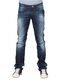
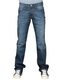
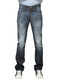
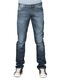
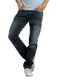
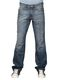
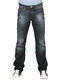
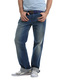
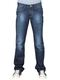
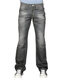
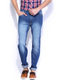
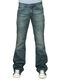
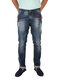
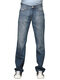

In [ ]:
display_result(imgs)

It's possible to prioritize our search based on either sparse or dense vector results.

To do so, we can scale the vectors, and for this we'll use a function named `hybrid_scale()`.

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

First, let us do a pure Sparse vector search by setting the alpha value to 0.


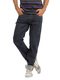
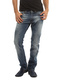
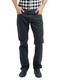
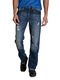
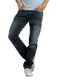
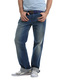
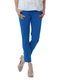
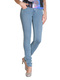
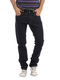
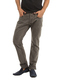
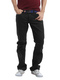
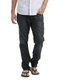
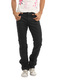
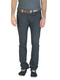

In [ ]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's take a look at the description of the result.

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Grey Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans


We observe that the keyword search results returned only French Connection jeans, which is a good start, but it wasn't satisfactory enough because, for example, it failed to rank a few men's French Connection jeans higher than a few of the women's, even though the query **"dark blue french connection jeans for men"** was obviously for men's jeans. That means, as expected, we couldn't fully get the results we wanted with just the Sparse vector search.

Now let's do a pure Semantic Image Search with the Dense embeddings from CLIP by setting the alpha value to 1.


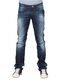
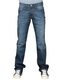
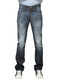
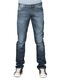
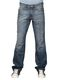
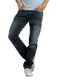
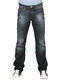
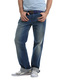
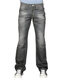
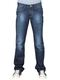
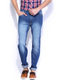
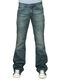
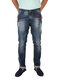
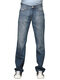

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Barney Grey Jeans
Locomotive Men Lio Blue Jeans
John Players Men Blue Jeans
Locomotive Men Rafe Blue Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Locomotive Men Lain Blue Jeans


The Semantic Image Search correctly returned results relating to blue jeans for men, but **failed to match the exact brand we are looking for — French Connection.** So, it's obvious a hybrid of Dense and Sparse vectors is required for us to get what we're really looking for - semantically similar products but only from the same brand, French Connection.

Let's now set the alpha value to `0.05` (5%) to try a hybrid search that is still mostly Sparse but has a 5% Dense component as well.


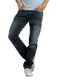
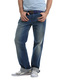
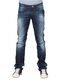
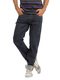
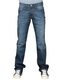
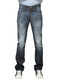
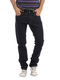
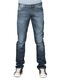
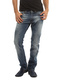
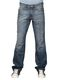
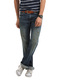
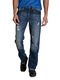
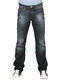
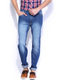

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Radley Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
French Connection Men Navy Blue Jeans
Locomotive Men Cam Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
John Players Men Blue Jeans


This seems to have produced better results - by performing a mostly Sparse search with some help from our image-based Dense vectors, **we get a good number of French Connection jeans, all the search results are from men's jeans and are aligned to blue jeans as well.**

Let's try this again with more queries:

### **7.2 Query 2: Small Beige Handbag for Women**

As earlier, **let's start with a completely Sparse search**, with alpha = 0.


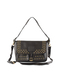
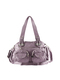
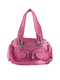
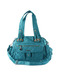
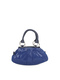
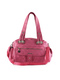
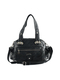
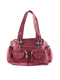
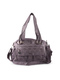
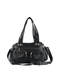
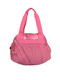
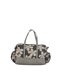
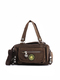
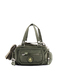

In [ ]:
query = "small beige handbag for women"
# create sparse and dense vectors
sparse = bm25.transform_query(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

**We get a lot of small handbags for women, but they're not beige.**

Let's introduce 5% of the image-based Dense vectors (alpha = 0.05) to assign a bit of importance to the semantic similarity needed to obtain the beige color specified in the query.


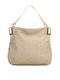
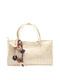
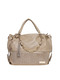
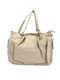
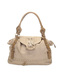
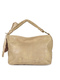
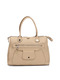
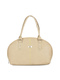
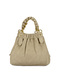
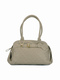
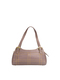
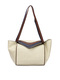
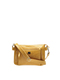
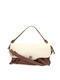

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Rocky S Women Beige Handbag
Kiara Women Beige Handbag
Lino Perros Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Baggit Women Beige Handbag
French Connection Women Beige Handbag
Murcia Women Beige Handbag
Rocia Women Beige Handbag
Baggit Women Beige Handbag
Murcia Women Mauve Handbag
French Connection Women Beige Handbag
Nyk Women Mustard Biker Sling Bag
Nyk Women Brown Alpine Handbag


These are clearly better aligned handbags - they're all beige handbags for women.

Let's look at what would've happened if we were to solely rely on the image-based Dense vectors.


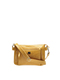
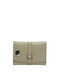
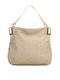
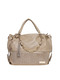
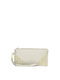
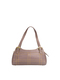
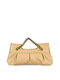
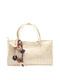
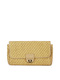
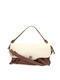
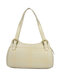
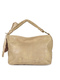
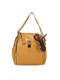
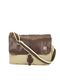

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

If we go too far with Dense vectors, we start to see a few purses, rather than handbags, and hence, that's not a great solution for us either.

### **7.3 Query 3: Soft Purple Topwear**

Let's run another interesting query.

This time, we will attempt another level of innovation by **using a product image itself** to create our Dense vector. We'll provide a text query too, as that will be used to create the Sparse vector up front, and then we'll select a specific color as per the metadata attached to each image, with [metadata filtering](https://docs.pinecone.io/docs/metadata-filtering).

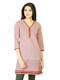

In [ ]:
images[36254]

We have chosen an alpha = 0.3 (30% Dense component)


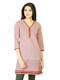
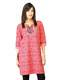
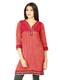
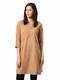
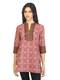
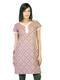
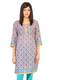
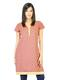
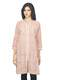
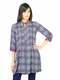
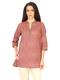
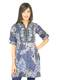
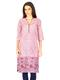
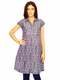

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.transform_query(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Our "purple" component isn't being considered strongly enough.

Let's add this to the metadata filtering:


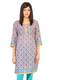
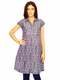
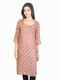
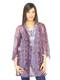
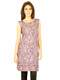
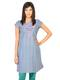
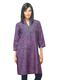
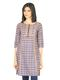
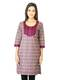
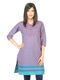
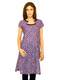
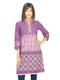
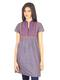
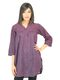

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.transform_query(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index_grpc.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

This time - the results are much better.

**Essentially, we have used filtering to reduce the search space to only products that are known to be of the purple color.** Within that reduced search space, our Semantic Search with a 30% Dense component from the image query, was able to give us highly relevant results, which are purple top wear items that are similar to the image we provided.

It's also noticeable that we got very accurate search results despite providing very little information in the text query - despite not providing any information about gender for example, the search results were all female product images, this is due to the high-quality semantic CLIP embedding generated directly from the image query.

## **8. Deleting the Index**

If you're done with the index, we can delete it to save resources.

In [ ]:
#pinecone.delete_index(index_name)

---

## **9. Conclusions**

As we see from this case study, the state of Natural Language Understanding, and its increasing unification with Vision at an embedding level, means that Semantic Search Engine prototypes can be built in a better way than by relying purely on Dense Embeddings from text queries only. We can use Hybrid approaches to combine Dense and Sparse Embeddings to obtain results closer to what the user may be looking for directly from text. We can also leverage models that have understood the Semantic Latent Space for images, such as OpenAI's CLIP, to add image-based querying to a Hybrid Search Engine solution - this has the potential to reduce user effort in needing to provide precise text queries, and improving search capability in finding relevant results even further.